# 임베딩을 이용한 관광지 추천 타당성 평가
유사 관광지 추천 기능을 구현하기 위해 텍스트 임베딩을 기반으로 한 유사도 검색을 사용하고자 한다. 임베딩은 임의 형태의 데이터를 다차원 공간에 맵핑한 결과이며, 임베딩 공간은 보통 유사한 아이템은 가까워지도록, 상이한 아이템은 멀어지도록 학습되기 떄문에 거리를 기반으로 유사한 아이템을 찾아낼 수 있다. 사전 학습된 모델을 이용해 관광지 설명 텍스트에 대한 임베딩을 생성했고, 그것을 활용한 추천 시스템이 타당한지 검증해보기 위해 아래의 관찰들을 수행했다.

- **임베딩 클러스터 시각화**: t-SNE를 활용해 임베딩 벡터를 2차원 공간에 맵핑합니다. 시각화를 통해 임베딩 벡터들이 클러스터를 구성하는지 살펴봅니다.
- **검색 성능 평가**: k-NN(k-Nearest Neighbor)를 이용해 top-k 관광지를 찾고 유사한 아이템이 추천되는지 살펴봅니다.
  - **정량 평가**: 관광지 태그 데이터를 라벨로 활용해 top-k 검색 결과를 Precision@K로 평가합니다.
  - **정성 평가**: top-k 검색 결과를 사람이 직접 평가합니다.

## 임베딩 클러스터 시각화(t-SNE)

In [1]:
import pandas as pd
import json
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
def plot_tsne_by_tag(x: list, tags: list[str], perplexity: float, max_iter: int):
    x = np.asarray(x)
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate='auto',
        max_iter=max_iter,
        init='pca',
        verbose=1
    )
    transformed_x = tsne.fit_transform(x)

    tags = pd.Series(tags, dtype='category')
    plt.figure(figsize=(8,6))
    for cat in tags.cat.categories:
        m = (tags == cat).to_numpy()
        plt.scatter(transformed_x[m,0], transformed_x[m,1], s=12, alpha=0.8, label=str(cat))
    
    plt.title('t-SNE')
    plt.tight_layout()
    plt.show()

In [3]:
embedding_df = pd.read_csv('./assets/tourspot_embeddings.csv')
tourspots_df = pd.read_csv('./assets/tourspots_full_transformed.csv')

tourspots_df['tags'] = tourspots_df['tags'].apply(lambda x: json.loads(x)[0])

merged = pd.merge(tourspots_df, embedding_df, on='id')

merged.drop_duplicates(subset=['id', 'embedding'], inplace=True)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4336 samples in 0.005s...
[t-SNE] Computed neighbors for 4336 samples in 3.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4336
[t-SNE] Computed conditional probabilities for sample 2000 / 4336
[t-SNE] Computed conditional probabilities for sample 3000 / 4336
[t-SNE] Computed conditional probabilities for sample 4000 / 4336
[t-SNE] Computed conditional probabilities for sample 4336 / 4336
[t-SNE] Mean sigma: 0.103354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.297356
[t-SNE] KL divergence after 2000 iterations: 1.745163


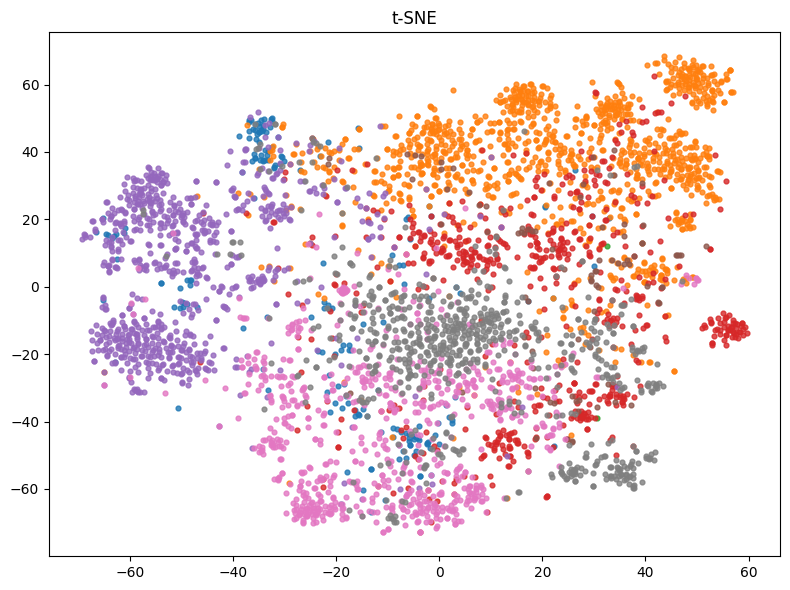

In [4]:
plot_tsne_by_tag(
    x=merged['embedding'].apply(json.loads).to_list(),
    tags=merged['tags'].to_list(),
    perplexity=40,
    max_iter=2000
)

각 점은 하나의 관광지를 표현하고 점의 색깔은 관광지 태그를 의미합니다. 같은 색의 점이 모이는 경향성을 확인할 수 있고, 이를 통해 같은 태그를 가지는 관광지들이 임베딩 공간 상에서도 유사하게 평가된다는 것을 알 수 있습니다. 따라서 거리 기반 알고리즘으로 유사한 관광지가 추천될 것이라고 기대할 수 있습니다.

# 검색 성능 평가
## 정량 평가(Precision@K)
k-NN 알고리즘을 이용해 top-k 유사 관광지를 뽑아보았다. 평가 기준은 관광지 태그를 기준으로 계산한 Precision@K 점수이다. top-k 추천 결과에 같은 태그를 가지는 관광지가 많을수록 점수가 높아진다. 검증을 위해 단순 무작위 추출했을 때의 점수와 임베딩 공간에서 k-NN을 이용해 추출했을 때의 점수를 비교했다.

k-NN을 이용해 top-k 관광지를 선정할 경우 무작위 추출한 경우와 비교했을 때보다 확실히 더 높은 점수를 기록하는 것을 확인할 수 있다. 또한 점수가 낮은 경우(Precision@K < 0.2인 경우)를 살펴봐도 태그만 다를 뿐 유사한 관광지가 선정된 것을 확인할 수 있다.

In [5]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)
nn.fit(merged['embedding'].apply(json.loads).to_list())

,n_neighbors,11
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [6]:
def precision_at_k(query, neighbors, tags, k=10):
    query_tag = tags[query]
    neighbor_tags = [tags[i] for i in neighbors[:k]]
    correct = sum(1 for t in neighbor_tags if t == query_tag)
    return correct / k

Random sampling - Precision@k: 0.18650830258302584


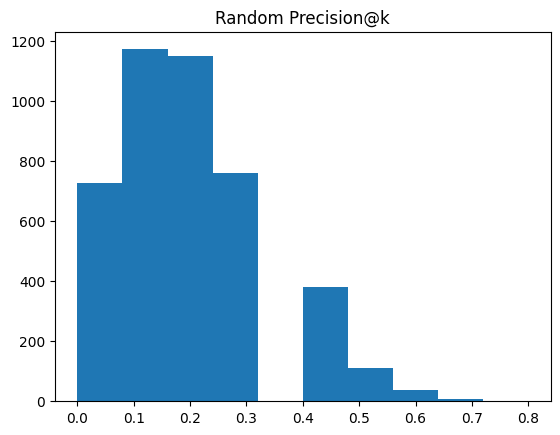

In [8]:
import random

neighbor_idx = [[random.randint(0, len(merged)-1) for _ in range(10)] for _ in range(len(merged))]

pak = []
for i in range(len(merged)):
    score = precision_at_k(i, neighbor_idx[i], merged['tags'], 10)
    pak.append(score)
print('Random sampling - Precision@k:', sum(pak) / len(merged))
plt.hist(pak, bins=10)
plt.title('Random Precision@k')
plt.show()

KNN sampling - Precision@k: 0.6507380073800738


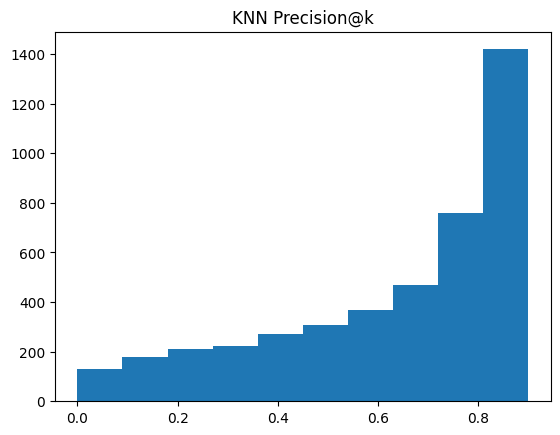

In [9]:
dist, neighbor_idx = nn.kneighbors(merged['embedding'].apply(json.loads).to_list())

pak = []
low_score_idx = []
for i in range(len(merged)):
    score = precision_at_k(i, neighbor_idx[i][1:10], merged['tags'], 10)
    pak.append(score)
    if score <= 0.2:
        low_score_idx.append(i)
print('KNN sampling - Precision@k:', sum(pak) / len(merged))
plt.hist(pak, bins=10)
plt.title('KNN Precision@k')
plt.show()

In [13]:
for i in low_score_idx[:3]:
    qi = neighbor_idx[i][0]
    query = merged.iloc[qi]
    neighbors = neighbor_idx[i][1:10]

    print('[검색 관광지]')
    print(query['name'], '-', query['tags'], '-', query['description'])
    print()

    print('[이웃 관광지]')
    for ni in neighbors:
        neighbor = merged.iloc[ni]
        print(neighbor['name'], '-', neighbor['tags'], '-', neighbor['description'])
        print()

[검색 관광지]
제주힐링명상센터 (무병장수테마파크) - EXPERIENCE - 제주 애월읍 중산간 400고지에 자리한 제주힐링명상센터는 명상 분야의 자격을 갖추고 오랜 기간 전문성을 키워온 운영 인력과 함께 체계적이고 전문화된 힐링 및 체험 프로그램을 보유한 테마파크이다. 한국 고유의 호흡법과 명상, 기문화 전파를 통해 행복한 삶을 추구하는 공간이 되고 있으며 2021년 제주 웰니스 관광지로 선정됐다. 무병장수테마파크로도 불린다.
자연이 선물한 드넓은 들판이 있고 한림해변과 비양도를 품은 바다가 한눈에 내려다보이는 곳에 위치한 교육 및 연수용 강의장, 아름답게 꾸민 일지기(氣)가든, 역사문화공원, 자연쉼터에서 가볍게 산책을 즐기기 좋다. 또 다른 시설 국궁장에서는 국궁지도사의 전문지도를 통하여 전통 활 쏘기의 프로그램을 경험할 수 있다. 
힐링명상센터에서는 야외와 동굴을 오가며 명상을 즐기는 자연명상 체험을 비롯해 기체조, 단전돌찜질, 치유명상, 율려명상 등을 운영하고 있다. 오프라인 체험뿐만 아니라 온라인 채널을 통해 명상, 체조 등 심도 높은 자연치유 요법 콘텐츠를 제공하기도 한다. 체험 예약은 사전에 인터넷으로 신청 또는 전화로 문의해야 한다.

[이웃 관광지]
서귀포 치유의 숲 - REST - 자연 속에서 조용히 나의 내면을 성찰하고, 숲에 존재하는 다양한 환경과 접하며 치유의 시간을 가질 수 있는 곳, 바로 서귀포 치유의 숲이다. 치유의 숲은 제주도에서도 손꼽히는 자연을 가진 곳이다. 해발 320~760m에 위치해 있으며, 난대림, 온대림, 한대림의 다양한 식생이 고루 분포하고 있다. 특히, 평균 수령 60년 이상의 전국 최고의 편백 숲이 여러 곳에 조성되어 있다. 또한, 인근의 헬스케어타운 등 의료, 관광산업과 연계 가능한 특색 있는 복합형 휴양 및 치유공간이다. 인체의 면역력을 높이고 건강 증진을 목적으로 다양한 산림의 환경 요소를 활용하여 산림치유지도사가 산림치유프로그램을 진행하고 있다. 바쁜 스케줄로 자신을 돌볼 여유가 없는 현대인들에게 숲 속

## 정성 평가(추천 아이템 직접 평가)
관광지를 무작위 추출해 추천되는 유사 관광지를 직접 평가해봤다. 대체로 유사한 관광지가 추천되는 것을 확인할 수 있다.

In [ ]:
import random

choice = random.choice(range(len(merged)))

query = merged.iloc[choice]
print('[검색 관광지]')
print(query['name'], '-', query['description'])
print()

print('[이웃 관광지]')
for ni in neighbor_idx[choice]:
    neighbor = merged.iloc[ni]
    print(neighbor['name'], '-', neighbor['description'])
    print()

[검색 관광지]
창천근린공원 - 창천근린공원은 서울특별시 서대문구 창천동에 위치한 도심 속 공원이다. 이 공원은 창천동 주민들의 휴식과 여가를 위해 조성된 녹지 공간이다.
공원은 다양한 나무와 잔디밭이 있어 자연 속에서 산책하거나 피크닉을 즐길 수 있는 환경을 제공한다. 주요 시설로는 산책로, 벤치, 운동기구 등이 있으며, 주민들에게 건강과 여가를 동시에 제공하는 역할을 한다.
창천근린공원은 특히 가족 단위 방문객들에게 적합한 곳이다. 어린이들을 위한 놀이시설과 운동을 위한 공간이 잘 마련되어 있어 세대 간 소통과 여가를 누릴 수 있는 장소로 알려져 있다.
이 공원은 바람산어린이공원과 가까운 곳에 위치해 있으며, 신촌 지역의 생활권 공원으로서 주민들에게 편리한 접근성을 제공한다.
창천근린공원은 계절마다 다양한 풍경을 감상할 수 있는 곳으로, 봄에는 꽃이 만발하고 가을에는 단풍으로 물들어 방문객들에게 자연의 변화를 체험할 기회를 준다.

[이웃 관광지]
대현문화공원 - 서울에 있는 대현문화공원은 서울특별시 서대문구 대현동에 위치한 공원이다. 이 공원은 지역 주민들에게 자연과 여가 공간을 제공하며, 주변 도심 속에서 휴식을 취할 수 있는 장소로 사랑받고 있다.
<br />대현문화공원은 다양한 산책로와 조경이 잘 어우러진 녹지 공간을 갖추고 있으며, 지역 주민들의 건강과 여가 활동을 지원하기 위한 운동기구와 휴식 공간이 마련되어 있다. <br />특히, 근린공원이라는 특성상 지역 주민들이 자주 찾는 친근한 장소로 알려져 있다.

거리공원 - 구로거리공원은 서울 구로구에 위치한 공원으로, 지역 주민들의 여가와 휴식을 위한 공간이다. 구로구 거리공원오거리에서 신도림역에 이르는 보조 간 선급 가로를 거리공원길이라고 하는데, 구로 거리공원을 따라 이어진 길이라는 의미에서 거리공원길이라고 이름 붙였다.  산책로, 운동기구 등이 갖추어져 있어 운동과 산책을 즐길 수 있다. 공원 내에는 어린이 놀이시설도 마련되어 있어 가족 단위 방문객들에게 인기가 많다. 다양한 나무와 꽃들이 